In [41]:
from valurap import path_planning
import imp
imp.reload(path_planning)

%matplotlib inline
import pandas as pd


In [42]:
from math import sqrt
from numpy import array, absolute, isnan
from numpy.linalg import norm

from valurap import printer, commands
from valurap.asg import Asg, ProfileSegment, PathSegment

path_deltas = [
    [100.0, 100.0, 200.0],
    [100.0, -100.0, 100.0],
    [100.0, -200.0, 200.0],
    [-150.0, -50.0, 150.0],
    [-150.0, 150.0, 150.0],
    [10.0, -200.0, 200.0],
    [50.0, 200.0, 200.0],
    [-60.0, 100.0, 200.0],
] * 3

path_deltas = [
    [120.0, -0.0, 250.0],
    [-0.0, 120.0, 250.0],
    [-120.0, 50.0, 250.0],
    [50.0, -120.0, 250.0],
    [-50.0, -50.0, 150.0],
] * 3

path_deltas = [
    [10, 250.0, 200.0],
    [1, 25.0, 50.0],
    [2, 0.0, 30.0],
    [-1, -25.0, 50.0],
    [-10, -250.0,  200.0],
    [-1, -25.0, 50.0],
    [-2, 0.0, 30.0],
    [1, 25.0, 50.0],
] * 10

 
path_deltas = []
l = 30
v = 160

for i in range(0, 10):
    k = 2 - 0.05 * i
    k2 = 2 - 0.05 * (i + 0.5)
    path_deltas.append([   k*l,      0, v])
    path_deltas.append([       0, -k*l, v])
    path_deltas.append([ -k2*l,      0, v])
    path_deltas.append([       0, k2*l, v])
    

path = []
x = 0
y = 0
for dx, dy, speed in path_deltas:
    x += dx
    y += dy
    path.append([x, y, speed])
    
print(path)

pr_opt = path_planning.plan_path(path)
import warnings
warnings.filterwarnings("error")

steps_opt = path_planning.emulate(pr_opt, 0)
steps_opt = pd.DataFrame(steps_opt)




[[60.0, 0, 160], [60.0, -60.0, 160], [0.75, -60.0, 160], [0.75, -0.75, 160], [59.25, -0.75, 160], [59.25, -59.25, 160], [1.5, -59.25, 160], [1.5, -1.5, 160], [58.5, -1.5, 160], [58.5, -58.5, 160], [2.25, -58.5, 160], [2.25, -2.25, 160], [57.75, -2.25, 160], [57.75, -57.75, 160], [3.0, -57.75, 160], [3.0, -3.0, 160], [57.0, -3.0, 160], [57.0, -57.0, 160], [3.75, -57.0, 160], [3.75, -3.75, 160], [56.25, -3.75, 160], [56.25, -56.25, 160], [4.5, -56.25, 160], [4.5, -4.5, 160], [55.5, -4.5, 160], [55.5, -55.5, 160], [5.25, -55.5, 160], [5.25, -5.25, 160], [54.75, -5.25, 160], [54.75, -54.75, 160], [6.0, -54.75, 160], [6.0, -6.0, 160], [54.0, -6.0, 160], [54.0, -54.0, 160], [6.75, -54.0, 160], [6.75, -6.75, 160], [53.25, -6.75, 160], [53.25, -53.25, 160], [7.5, -53.25, 160], [7.5, -7.5, 160]]
speeds: [0 0] [160.   0.] [   0. -160.]
avails: [0 0] [60.  0.] [  0. -30.]
enter_delta_v: [160.   0.]
enter_time: 0.05333333333333334
enter_a: [3000.    0.]
enter_delta_x: [4.26666667 0.        ]
enter

decel_end: [57.         -7.26666667]
accel_start: [ 7.25301334 -8.30088489]
target_x: [49.74698666  1.03421822]
args_x: {'in_v': 130719, 'target_plato_v': 1099512, 'target_out_v': 0, 'target_x': 3980, 'accel_t': 59, 'plato_t': 225, 'decel_t': 53}
args_y: {'in_v': 1216484, 'target_plato_v': 0, 'target_out_v': -1099512, 'target_x': 83, 'accel_t': 59, 'plato_t': 225, 'decel_t': 53}
sol_x: {'accel_j': 109435472, 'accel_jj': -3709677, 'plato_v': 1227311.3862609863, 'decel_j': -152375318, 'decel_jj': 5750012, 'accel_x': 421.83297345879106, 'plato_x': 3214.75162530227, 'decel_x': 343.41540124103176}
sol_y: {'accel_j': -137414806, 'accel_jj': 4658129, 'plato_v': -234.54617309570312, 'decel_j': -152375318, 'decel_jj': 5750012, 'accel_x': 418.59918571702786, 'plato_x': -0.6143572850447754, 'decel_x': -334.984828421625}
i: 16

speeds: [ 1.78597313e+02 -3.41309603e-02] [   0. -160.] [-160.    0.]
avails: [44.47407449 -4.1982716 ] [  0.         -49.73333333] [-26.625   0.   ]
enter_delta_v: [-178.5

enter_delta_v: [180.0336737  159.57032366]
enter_time: 0.06001122456522623
enter_a: [3000.         2659.00795747]
enter_delta_x: [-5.40202061  4.81379067]
enter_t_first: [0.03000561 0.03000561]
enter_t_second: [0.03000561 0.03000561]
enter_need_first: [-5.40202061  0.0128927 ]
enter_need_second: [0.         4.80089797]
in_avail assert: [  7.79229894 331.32005603]
exit_delta_v: [ 160. -160.]
exit_time: 0.05333333333333334
exit_a: [ 3000. -3000.]
exit_delta_x: [4.26666667 4.26666667]
exit_t_first: [0.02666667 0.02666667]
exit_t_second: [0.02666667 0.02666667]
exit_need_first: [0.         4.26666667]
exit_need_second: [4.26666667 0.        ]
cur_avail assert: [10.00369579]
prev_plato_jerk: [ -1.04763032 -20.34455766]
cur_target: [ 4.5 -4.5]
decel_end: [ 8.76666667 -4.5       ]
accel_start: [  9.90201239 -51.99623943]
target_x: [-1.13534572 47.49623943]
args_x: {'in_v': -1229983, 'target_plato_v': 0, 'target_out_v': 1099512, 'target_x': -91, 'accel_t': 60, 'plato_t': 210, 'decel_t': 53}
ar

sol_y: {'accel_j': -131265656, 'accel_jj': 4303792, 'plato_v': -1408.1068115234375, 'decel_j': -152375318, 'decel_jj': 5750012, 'accel_x': 441.86991208334797, 'plato_x': -2.88508365429152, 'decel_x': -334.984828421625}
i: 36

speeds: [183.74323143  -0.20490651] [   0. -160.] [-160.    0.]
avails: [36.63696599 -4.22190267] [  0.         -42.23333333] [-22.875   0.   ]
enter_delta_v: [-183.74323143 -159.79509349]
enter_time: 0.06124774381148038
enter_a: [-3000.         -2608.99558982]
enter_delta_x: [ 5.62692918 -4.90609454]
enter_t_first: [0.03062387 0.03062387]
enter_t_second: [0.03062387 0.03062387]
enter_need_first: [ 5.62692918 -0.00627503]
enter_need_second: [ 0.        -4.8998195]
in_avail assert: [6.51100535]
exit_delta_v: [-160.  160.]
exit_time: 0.05333333333333334
exit_a: [-3000.  3000.]
exit_delta_x: [-4.26666667 -4.26666667]
exit_t_first: [0.02666667 0.02666667]
exit_t_second: [0.02666667 0.02666667]
exit_need_first: [ 0.         -4.26666667]
exit_need_second: [-4.26666667  

<IPython.core.display.Javascript object>


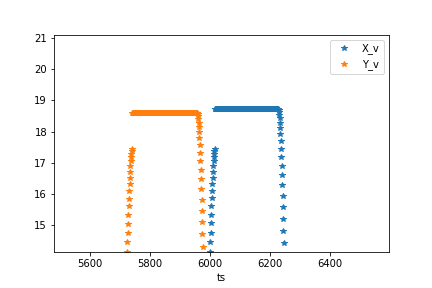

In [43]:
%matplotlib notebook
#steps_opt.plot(x = steps_opt["X_x"]/80, y = steps_opt["Y_x"]/80, style="*")

#steps_opt.plot(x = "ts", y = ["X_a", "Y_a"], style="*")
steps_opt.plot(x = "ts", y = ["X_v", "Y_v"], style="*")
#steps_opt.plot(x = "ts", y = ["X_x", "Y_x"], style="*")
if 0:
    steps_opt["X_x1"] = steps_opt["X_x"]/80
    steps_opt["Y_x1"] = steps_opt["Y_x"]/80

    steps_opt.plot(x = "X_x1", y = "Y_x1", style="*")

#code = p.asg.gen_path_code(pr_opt)
#print(len(code))
#print(code)
            

In [ ]:
path_deltas = []

for i in range(0, 20):
    k = 2 - 0.05 * i
    k2 = 2 - 0.05 * (i + 0.5)
    path_deltas.append([   k*100,      0, 50])
    path_deltas.append([       0, -k*100, 50])
    path_deltas.append([ -k2*100,      0, 50])
    path_deltas.append([       0, k2*100, 50])

path_deltas